In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
import argparse
from collections import Counter
import json
import re
import string
import nltk
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.cluster import DBSCAN
import numpy as np

In [2]:

posMapping = {
# "First_Letter by nltk.pos_tag":"POS_for_lemmatizer"
    "N":'n',
    "V":'v',
    "J":'a',
    "R":'r'
}

# 5% Credits
def process(text, lemmatizer=nltk.WordNetLemmatizer()):

    """ 
    Normalizes case and handles punctuation

    Parameters
    ----------
    text: str: 
        raw text
    lemmatizer: nltk.WordNetLemmatizer() 
        an instance of a class implementing the lemmatize() method
        (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    
    Returns
    -------
    list(str)
        tokenized text
    """

    # [Your Code Starts Here]

    text = text.lower()
    text = re.sub(r"http:/+[^ ]*", '', text)
    text = re.sub(r"https:/+[^ ]*", '', text)
    text = re.sub(r"www\.+[^ ]*", '', text)

    #remove punctuation
    text = re.sub(r"'s\b", '', text)
    text = re.sub(r"'", '', text)
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')

    split_text = text.split()
    pos_text = nltk.pos_tag(split_text)
    lemmatized_text = []
    for word, pos in pos_text:
        if pos[0] in posMapping:
            lemmatized_text.append(lemmatizer.lemmatize(word, posMapping[pos[0]]))
        else:
            lemmatized_text.append(lemmatizer.lemmatize(word, 'n'))

    return lemmatized_text



def filter_words(tokenized_text:list, words_to_filter:set):
    """
    Returns a tokens list with the words in `words_to_filter`
    filtered out

    Parameters
    ----------
    tokenized_text : list(str)
        List of text tokens
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    list(str)
        List of text tokens with words in
        `words_to_filter` filtered out
    """

    return [token for token in tokenized_text if token not in words_to_filter]

def create_features_tfidf(instructions:pd.DataFrame):
    """
    Compute TF-IDF features for the instructions dataset

    Parameters
    ----------
    instructions : pd.DataFrame
        Dataframe with a column named 'instruction'
        containing list of instructions
    
    Returns
    -------
    TfidfVectorizer()
        Instance of the class TfidfVectorizer
    scipy.sparse._csr_matrix
        TF-IDF feature matrix
    """

    vectorizer = TfidfVectorizer(
        min_df=2, 
        tokenizer=lambda x: x,
        lowercase=False,
    )

    tfidf_matrix = vectorizer.fit_transform(instructions['instruction'])
    
    return tfidf_matrix, vectorizer

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--batch_dir",
        type=str,
        required=True,
        help="The directory where the batch is stored.",
    )
    parser.add_argument(
        "--num_instructions",
        type=int,
        help="if specified, only generate instance input for this many instructions",
    )
    return parser.parse_args()


def top_25_hf_words(instructions_ser:pd.Series):
    """
    Returns the top 25 most commonly occurring words
    across all instructions in a series object containing
    a list of instruction texts

    Parameters
    ----------
    instructions_ser : pd.Series
        Series objects containing a list of instructions

    Returns
    -------
    set(str)
        Set of top 25 high frequency words
    """

    word_counts = Counter()

    for instruction in instructions_ser:
        word_counts.update(instruction)

    most_common = word_counts.most_common(25)

    return set(word for word, count in most_common)


def get_common_words():
    """
    Returns a set of common English connectives, articles, and prepositions
    that should be filtered out from text analysis.

    Returns
    -------
    set(str)
        Set of common words to filter
    """
    return {
        'the', 'and', 'or', 'but', 'nor', 'for', 'yet', 'so',
        'a', 'an', 'in', 'on', 'at', 'to', 'of', 'with', 'by',
        'as', 'from', 'into', 'during', 'including', 'until',
        'against', 'among', 'throughout', 'despite', 'towards',
        'upon', 'concerning', 'about', 'is', 'are', 'was', 'were',
        'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does',
        'did', 'will', 'would', 'shall', 'should', 'may', 'might',
        'must', 'can', 'could', 'i', 'you', 'he', 'she', 'it', 
        'we', 'they', 'me', 'him', 'her', 'us', 'them', 'that'
    }


In [3]:
batch_dir = "C:/Users/mansu/Documents/self-instruct/data/gpt3_generations"
with open(os.path.join(batch_dir, "machine_generated_instructions.jsonl")) as fin:
    lines = [json.loads(line)['instruction'] for line in fin]


lemmatized_lines = [process(line) for line in lines]

In [10]:
common_words = get_common_words()
filtered_lines = [filter_words(line, common_words) for line in lemmatized_lines]

UMAP dimensionality reduction to 2 dimensions with 'euclidean' distance measure.


c:\Users\mansu\anaconda3\envs\general\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\mansu\anaconda3\envs\general\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


                                            instruction    UMAP_1    UMAP_2
8704  [formulate, fitness, plan, tailor, specific, h... -0.077460  9.186261
4580  [develop, workout, plan, someone, specified, f... -0.075410  9.262644
8292  [create, workout, plan, week, base, available,... -0.072343  9.179996
4801  [construct, workout, routine, tailor, individu... -0.070344  9.218445
9083  [design, workout, plan, base, fitness, goal, c... -0.070223  9.199979


C:\Users\mansu\AppData\Local\Temp\ipykernel_20544\1228554720.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


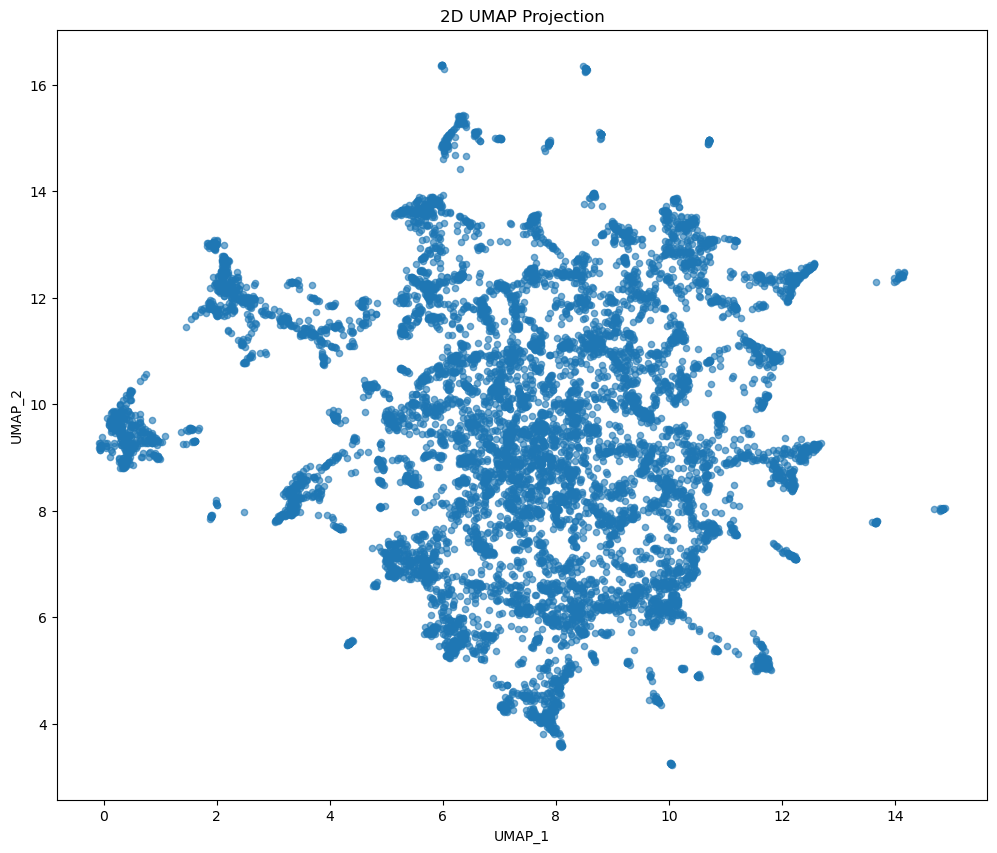

In [11]:

dmeasure = 'euclidean' # distance metric
rdims    = 2 # r-dims == Reduced dimensionality
print(f"UMAP dimensionality reduction to {rdims} dimensions with '{dmeasure}' distance measure.")


instructions_df = pd.DataFrame({'instruction': filtered_lines})

tfidf_matrix, vectorizer = create_features_tfidf(instructions_df)

# Apply UMAP
reducer = umap.UMAP(
    n_components=rdims,
    metric=dmeasure,
    random_state=42  # for reproducibility
)
embedding = reducer.fit_transform(tfidf_matrix)

embedding_df = pd.DataFrame(
    embedding,
    columns=[f'UMAP_{i+1}' for i in range(rdims)]
)

projected = instructions_df.join(embedding_df).sort_values(by=['UMAP_1','UMAP_2'])

print(projected.head())

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)  # Changed from (11, projection='2d')

scatter = ax.scatter(
    projected['UMAP_1'],
    projected['UMAP_2'], # Color by cluster
    cmap='tab20',
    s=20,
    alpha=0.6
)

ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
plt.title('2D UMAP Projection')
plt.show()


Original embedding shape: (10021, 2)
Scaled embedding shape: (10021, 2)


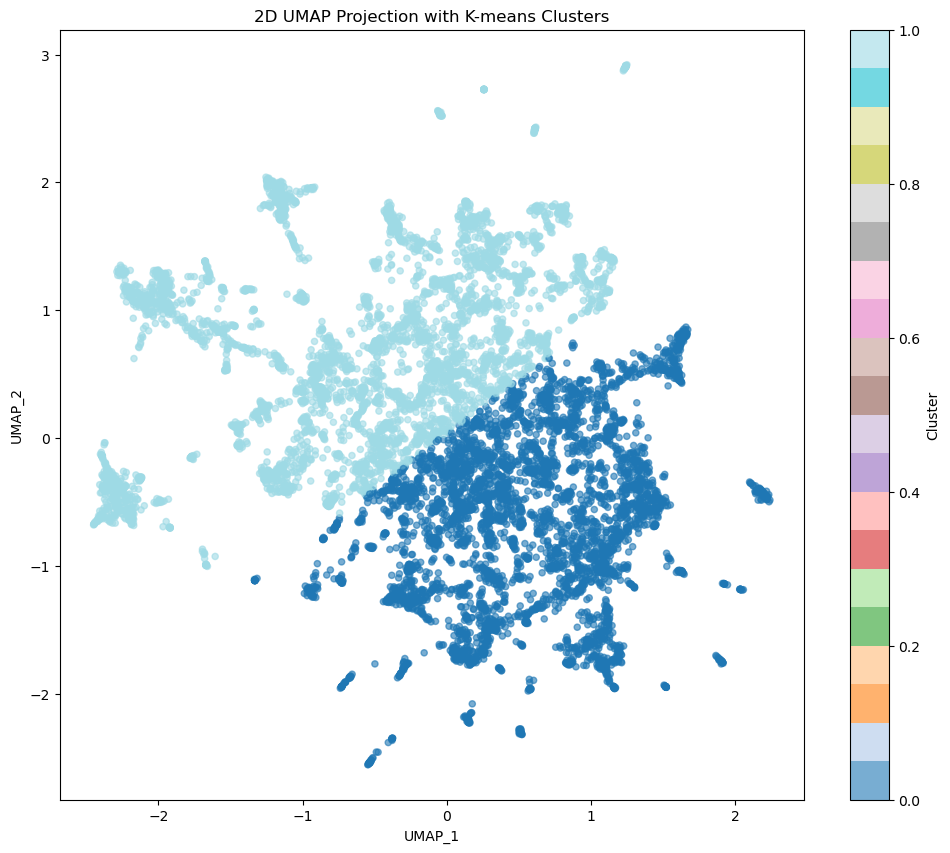


Cluster sizes:
Cluster 0: 5150 points
Cluster 1: 4871 points


In [31]:
# Let's first check the shape and format of our embeddings
print("Original embedding shape:", embedding.shape)

# Scale the embeddings
scaler = StandardScaler()
scaled_embedding = scaler.fit_transform(embedding)
print("Scaled embedding shape:", scaled_embedding.shape)

# Apply KMeans on the scaled embeddings
n_clusters = 2
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init='auto'
)

# Ensure embeddings are in the right format (dense array)
if scipy.sparse.issparse(scaled_embedding):
    scaled_embedding = scaled_embedding.toarray()

clusters = kmeans.fit_predict(scaled_embedding)

# Plot using the scaled coordinates
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

scatter = ax.scatter(
    scaled_embedding[:, 0],  # Use scaled coordinates directly
    scaled_embedding[:, 1],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.6
)

ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
plt.title('2D UMAP Projection with K-means Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Print cluster sizes
print("\nCluster sizes:")
for i in range(n_clusters):
    size = (clusters == i).sum()
    print(f"Cluster {i}: {size} points")

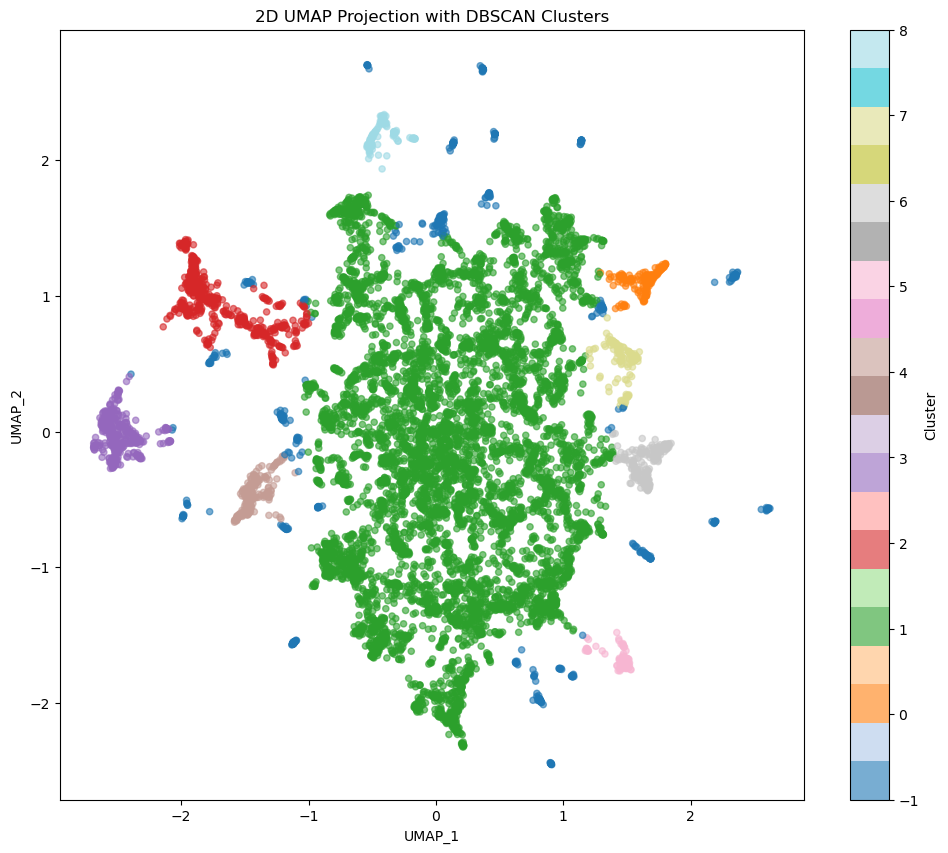


Cluster sizes:
Noise: 625 points
Cluster 0: 185 points
Cluster 1: 7429 points
Cluster 2: 552 points
Cluster 3: 398 points
Cluster 4: 217 points
Cluster 5: 115 points
Cluster 6: 216 points
Cluster 7: 154 points
Cluster 8: 130 points


In [13]:
from sklearn.cluster import DBSCAN
import numpy as np

# Scale the embeddings (reuse if you already have them scaled)
scaler = StandardScaler()
scaled_embedding = scaler.fit_transform(embedding)

# Apply DBSCAN
dbscan = DBSCAN(
    eps=0.2,          # Adjust this parameter as needed
    min_samples=100,    # Adjust this parameter as needed
)
clusters = dbscan.fit_predict(scaled_embedding)

# Plot using the scaled coordinates
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

scatter = ax.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.6
)

ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
plt.title('2D UMAP Projection with DBSCAN Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Print cluster sizes (including noise points labeled as -1)
print("\nCluster sizes:")
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
    size = (clusters == cluster).sum()
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"{label}: {size} points")

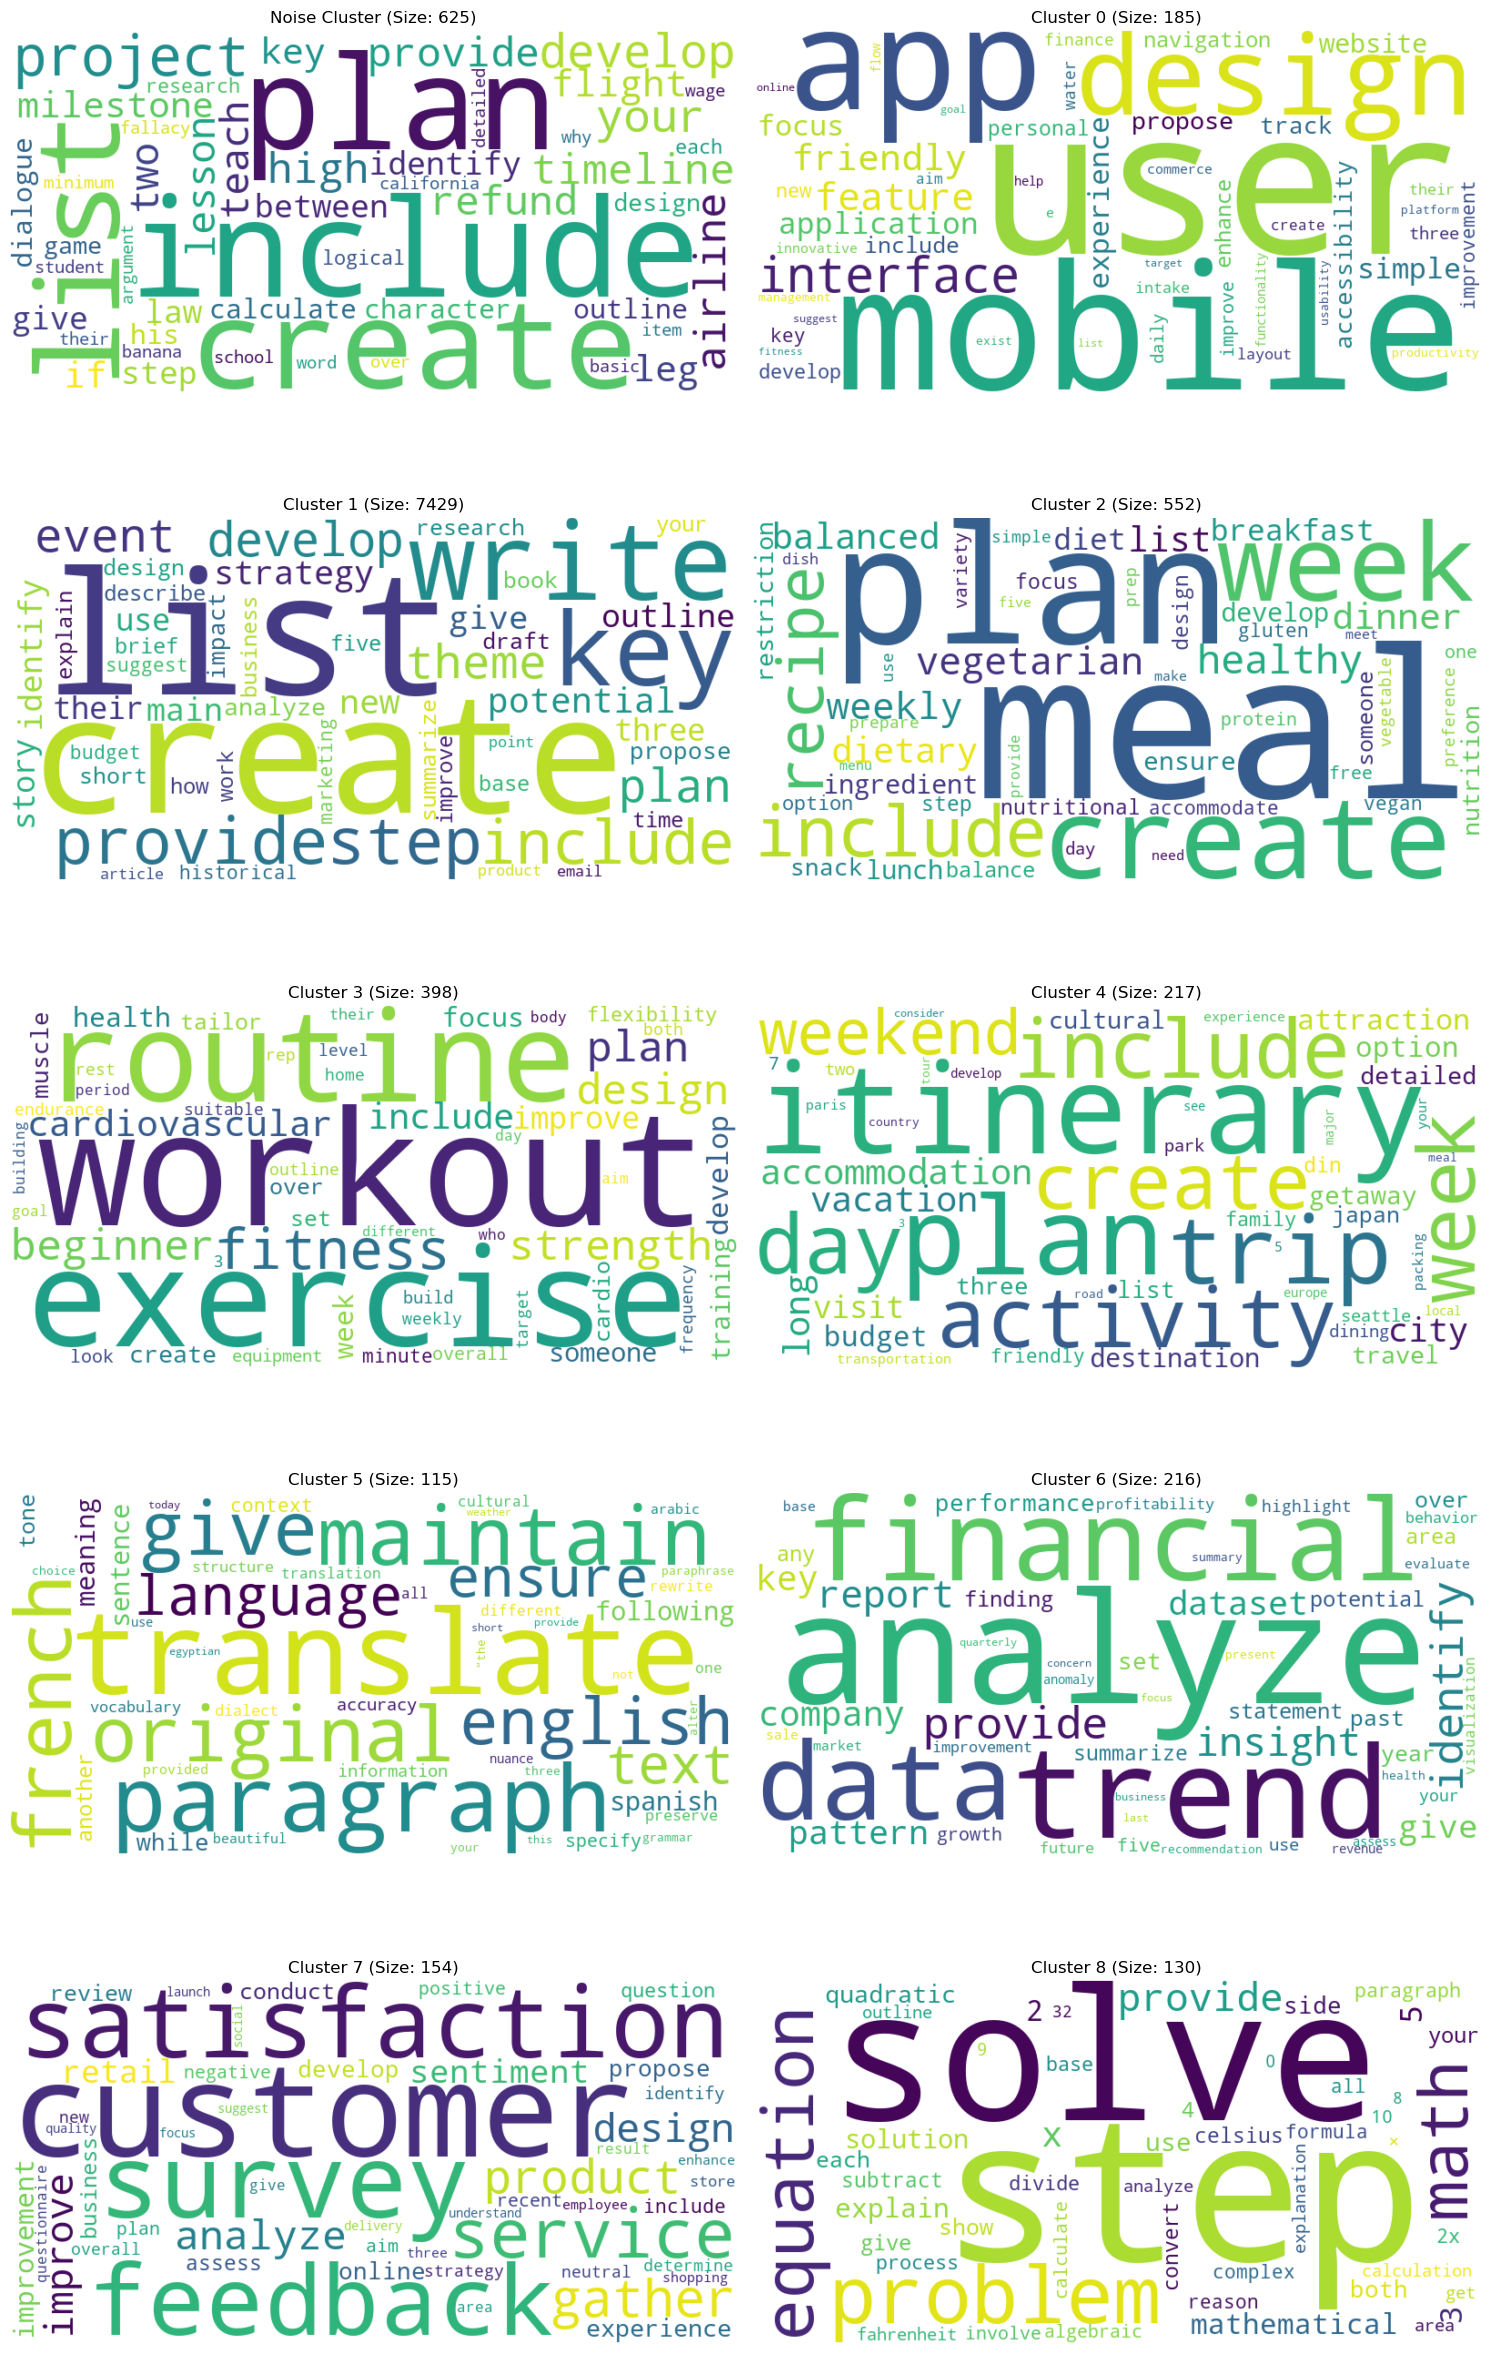


Example instructions from each cluster:

Noise examples:
- Create a detailed project plan for organizing a community event, including key milestones and deadlines.
- Fill in the blank with a word or phrase: "the quick brown fox jumps over the ______ dog."
- Task: decide whether the syllogism is logically sound. - analyze the premises and conclusion of a given syllogism to determine if it follows logical reasoning.

Cluster 0 examples:
- Design a simple user interface for a mobile app that tracks daily water intake.
- Design a user-friendly interface for a mobile app focused on fitness tracking and motivation.
- Design a user-friendly mobile app interface for a personal finance management tool, ensuring it includes key features such as budgeting, expense tracking, and financial goal setting.

Cluster 1 examples:
- Develop a machine learning model to predict house prices based on given features such as location, size, and number of bedrooms.
- Develop a step-by-step plan to improve time

In [15]:
from wordcloud import WordCloud

# Create a figure with subplots for each cluster
unique_clusters = sorted(np.unique(clusters))
n_clusters = len(unique_clusters)
fig = plt.figure(figsize=(15, 5 * ((n_clusters + 1) // 2)))

# For each cluster, create a wordcloud
for idx, cluster_id in enumerate(unique_clusters):
    # Get indices of points in this cluster
    cluster_mask = (clusters == cluster_id)
    
    # Get all words from instructions in this cluster
    cluster_words = []
    # Use a regular loop instead of numpy array operations
    for i, instruction in enumerate(filtered_lines):
        if cluster_mask[i]:
            cluster_words.extend(instruction)
    
    # Create word frequency dict
    word_freq = Counter(cluster_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(word_freq)
    
    # Add subplot
    ax = fig.add_subplot(((n_clusters + 1) // 2), 2, idx + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    label = "Noise Cluster" if cluster_id == -1 else f"Cluster {cluster_id}"
    ax.set_title(f'{label} (Size: {cluster_mask.sum()})')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print some example instructions from each cluster
print("\nExample instructions from each cluster:")
for cluster_id in unique_clusters:
    cluster_mask = (clusters == cluster_id)
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"\n{label} examples:")
    # Get original instructions (before lemmatization)
    cluster_examples = [line for i, line in enumerate(lines) if cluster_mask[i]]
    # Print first 3 examples
    for example in cluster_examples[:3]:
        print(f"- {example}")

UMAP dimensionality reduction to 3 dimensions with 'euclidean' distance measure.


c:\Users\mansu\anaconda3\envs\general\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\mansu\anaconda3\envs\general\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


                                            instruction    UMAP_1    UMAP_2  \
1650  [create, workout, plan, someone, look, improve...  1.607360  8.643115   
3803  [outline, workout, routine, build, muscle, mas...  1.618184  8.589716   
7276  [plan, one, week, workout, routine, build, mus...  1.629264  8.592445   
6711  [workout, plan, someone, look, build, muscle, ...  1.631726  8.647750   
1019  [design, workout, plan, someone, look, build, ...  1.633693  8.596253   

        UMAP_3  
1650  6.602485  
3803  6.403942  
7276  6.426113  
6711  6.530644  
1019  6.408308  


C:\Users\mansu\AppData\Local\Temp\ipykernel_20544\2327951236.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


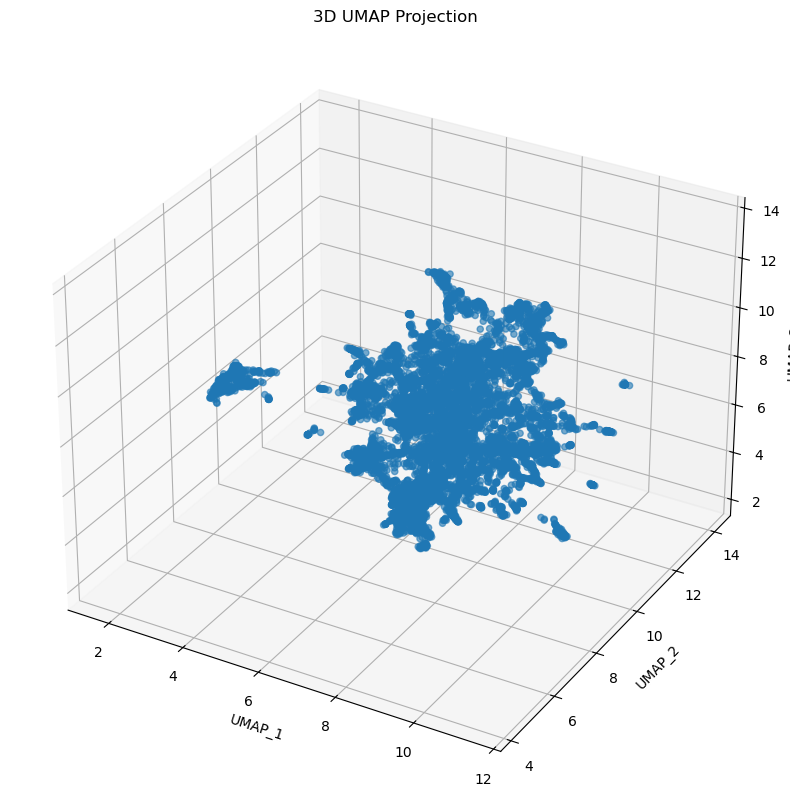

In [16]:

dmeasure = 'euclidean' # distance metric
rdims    = 3 # r-dims == Reduced dimensionality
print(f"UMAP dimensionality reduction to {rdims} dimensions with '{dmeasure}' distance measure.")


instructions_df = pd.DataFrame({'instruction': filtered_lines})

tfidf_matrix, vectorizer = create_features_tfidf(instructions_df)

# Apply UMAP
reducer = umap.UMAP(
    n_components=rdims,
    metric=dmeasure,
    random_state=42  # for reproducibility
)
embedding = reducer.fit_transform(tfidf_matrix)

embedding_df = pd.DataFrame(
    embedding,
    columns=[f'UMAP_{i+1}' for i in range(rdims)]
)

projected = instructions_df.join(embedding_df).sort_values(by=['UMAP_1','UMAP_2','UMAP_3'])

print(projected.head())

#3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')  # Changed from (11, projection='2d')

scatter = ax.scatter(
    projected['UMAP_1'],
    projected['UMAP_2'],
    projected['UMAP_3'], # Color by cluster
    cmap='tab20',
    s=20,
    alpha=0.6
)

ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
ax.set_zlabel('UMAP_3')
plt.title('3D UMAP Projection')
plt.show()


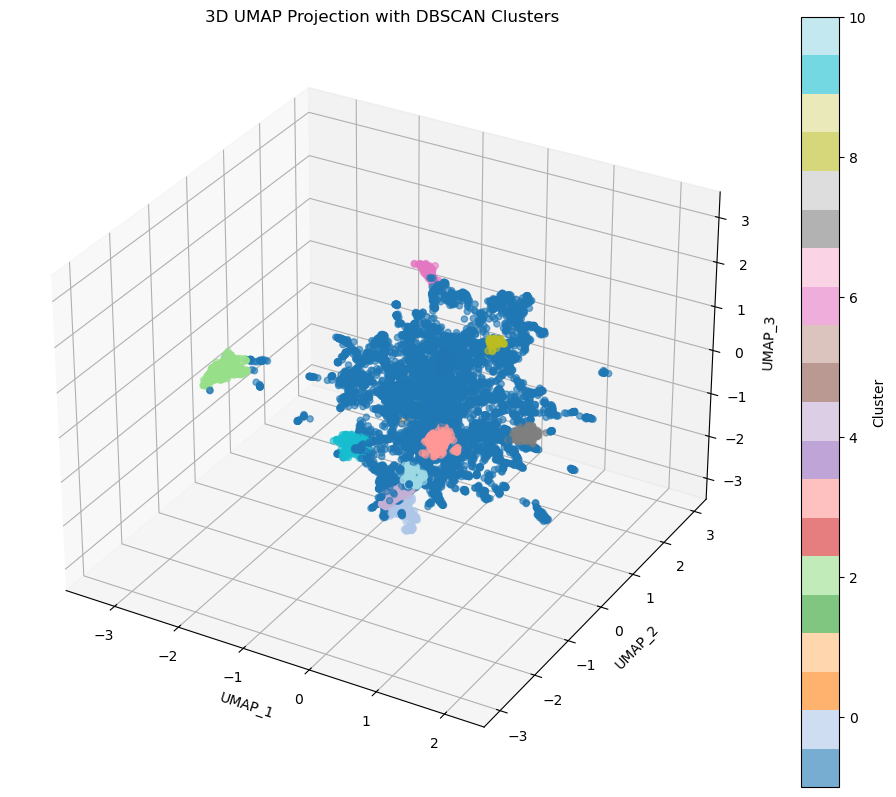


Cluster sizes:
Noise: 7841 points
Cluster 0: 306 points
Cluster 1: 189 points
Cluster 2: 341 points
Cluster 3: 200 points
Cluster 4: 248 points
Cluster 5: 180 points
Cluster 6: 136 points
Cluster 7: 156 points
Cluster 8: 107 points
Cluster 9: 193 points
Cluster 10: 124 points


In [17]:
#3d dbscan

# Scale the embeddings (reuse if you already have them scaled)
scaler = StandardScaler()
scaled_embedding = scaler.fit_transform(embedding)

# Apply DBSCAN
dbscan = DBSCAN(
    eps=0.2,          # Adjust this parameter as needed
    min_samples=100,    # Adjust this parameter as needed
)
clusters = dbscan.fit_predict(scaled_embedding)

# Plot using the scaled coordinates
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1],
    scaled_embedding[:, 2],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.6
)

ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
ax.set_zlabel('UMAP_3')
plt.title('3D UMAP Projection with DBSCAN Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Print cluster sizes (including noise points labeled as -1)
print("\nCluster sizes:")
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
    size = (clusters == cluster).sum()
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"{label}: {size} points")

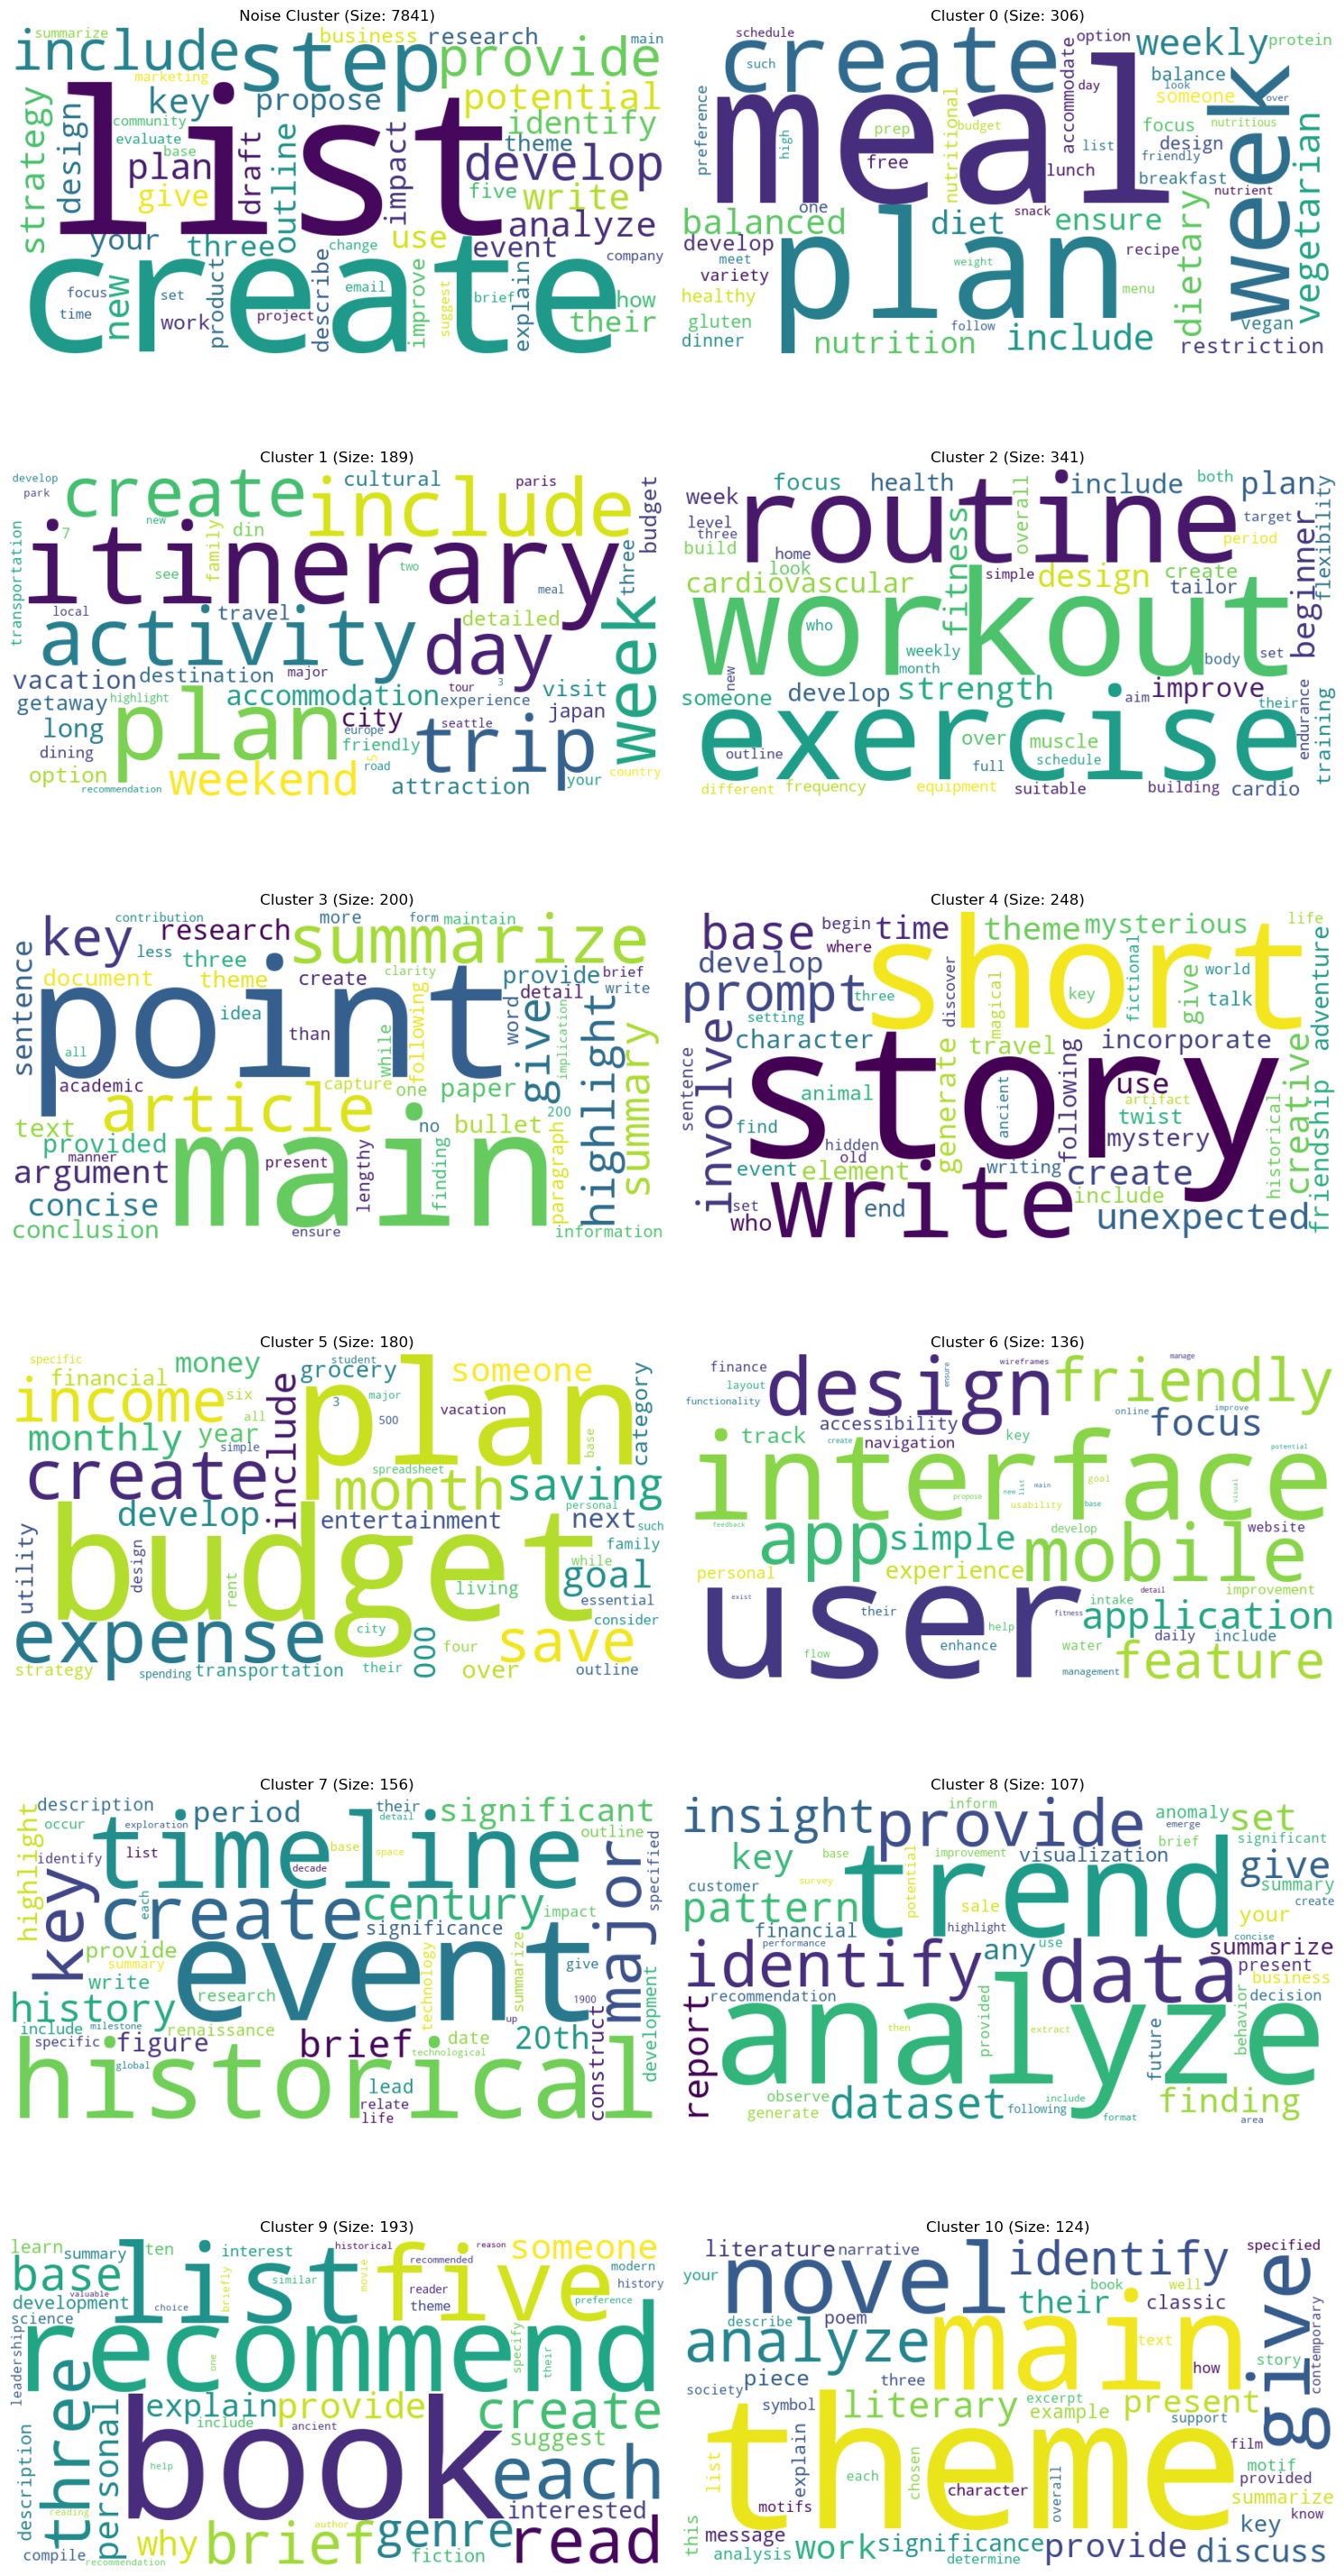


Example instructions from each cluster:

Noise examples:
- Develop a machine learning model to predict house prices based on given features such as location, size, and number of bedrooms.
- Develop a step-by-step plan to improve time management skills.
- Develop a marketing strategy for launching a new product in the tech industry.

Cluster 0 examples:
- Create a list of healthy meal options for someone following a vegetarian diet.
- Design a weekly meal plan that focuses on high-protein, low-carb meals for someone looking to build muscle and lose fat.
- Design a weekly meal plan that focuses on balanced nutrition, including all major food groups and accommodating dietary restrictions such as vegetarian or gluten-free options.

Cluster 1 examples:
- Develop a list of creative and engaging activities for a family weekend that cater to different age groups and interests, ensuring everyone has fun and quality time together.
- Provide a detailed itinerary for a 7-day trip to seattle, incl

In [18]:
# Create a figure with subplots for each cluster
unique_clusters = sorted(np.unique(clusters))
n_clusters = len(unique_clusters)
fig = plt.figure(figsize=(15, 5 * ((n_clusters + 1) // 2)))

# For each cluster, create a wordcloud
for idx, cluster_id in enumerate(unique_clusters):
    # Get indices of points in this cluster
    cluster_mask = (clusters == cluster_id)
    
    # Get all words from instructions in this cluster
    cluster_words = []
    # Use a regular loop instead of numpy array operations
    for i, instruction in enumerate(filtered_lines):
        if cluster_mask[i]:
            cluster_words.extend(instruction)
    
    # Create word frequency dict
    word_freq = Counter(cluster_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(word_freq)
    
    # Add subplot
    ax = fig.add_subplot(((n_clusters + 1) // 2), 2, idx + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    label = "Noise Cluster" if cluster_id == -1 else f"Cluster {cluster_id}"
    ax.set_title(f'{label} (Size: {cluster_mask.sum()})')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print some example instructions from each cluster
print("\nExample instructions from each cluster:")
for cluster_id in unique_clusters:
    cluster_mask = (clusters == cluster_id)
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"\n{label} examples:")
    # Get original instructions (before lemmatization)
    cluster_examples = [line for i, line in enumerate(lines) if cluster_mask[i]]
    # Print first 3 examples
    for example in cluster_examples[:3]:
        print(f"- {example}")

In [25]:

dmeasure = 'euclidean' # distance metric
rdims    = 6 # r-dims == Reduced dimensionality
print(f"UMAP dimensionality reduction to {rdims} dimensions with '{dmeasure}' distance measure.")


instructions_df = pd.DataFrame({'instruction': filtered_lines})

tfidf_matrix, vectorizer = create_features_tfidf(instructions_df)

# Apply UMAP
reducer = umap.UMAP(
    n_components=rdims,
    metric=dmeasure,
    random_state=42  # for reproducibility
)
embedding = reducer.fit_transform(tfidf_matrix)

embedding_df = pd.DataFrame(
    embedding,
    columns=[f'UMAP_{i+1}' for i in range(rdims)]
)

projected = instructions_df.join(embedding_df).sort_values(by=['UMAP_1','UMAP_2','UMAP_3','UMAP_4'])


UMAP dimensionality reduction to 6 dimensions with 'euclidean' distance measure.


c:\Users\mansu\anaconda3\envs\general\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\mansu\anaconda3\envs\general\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


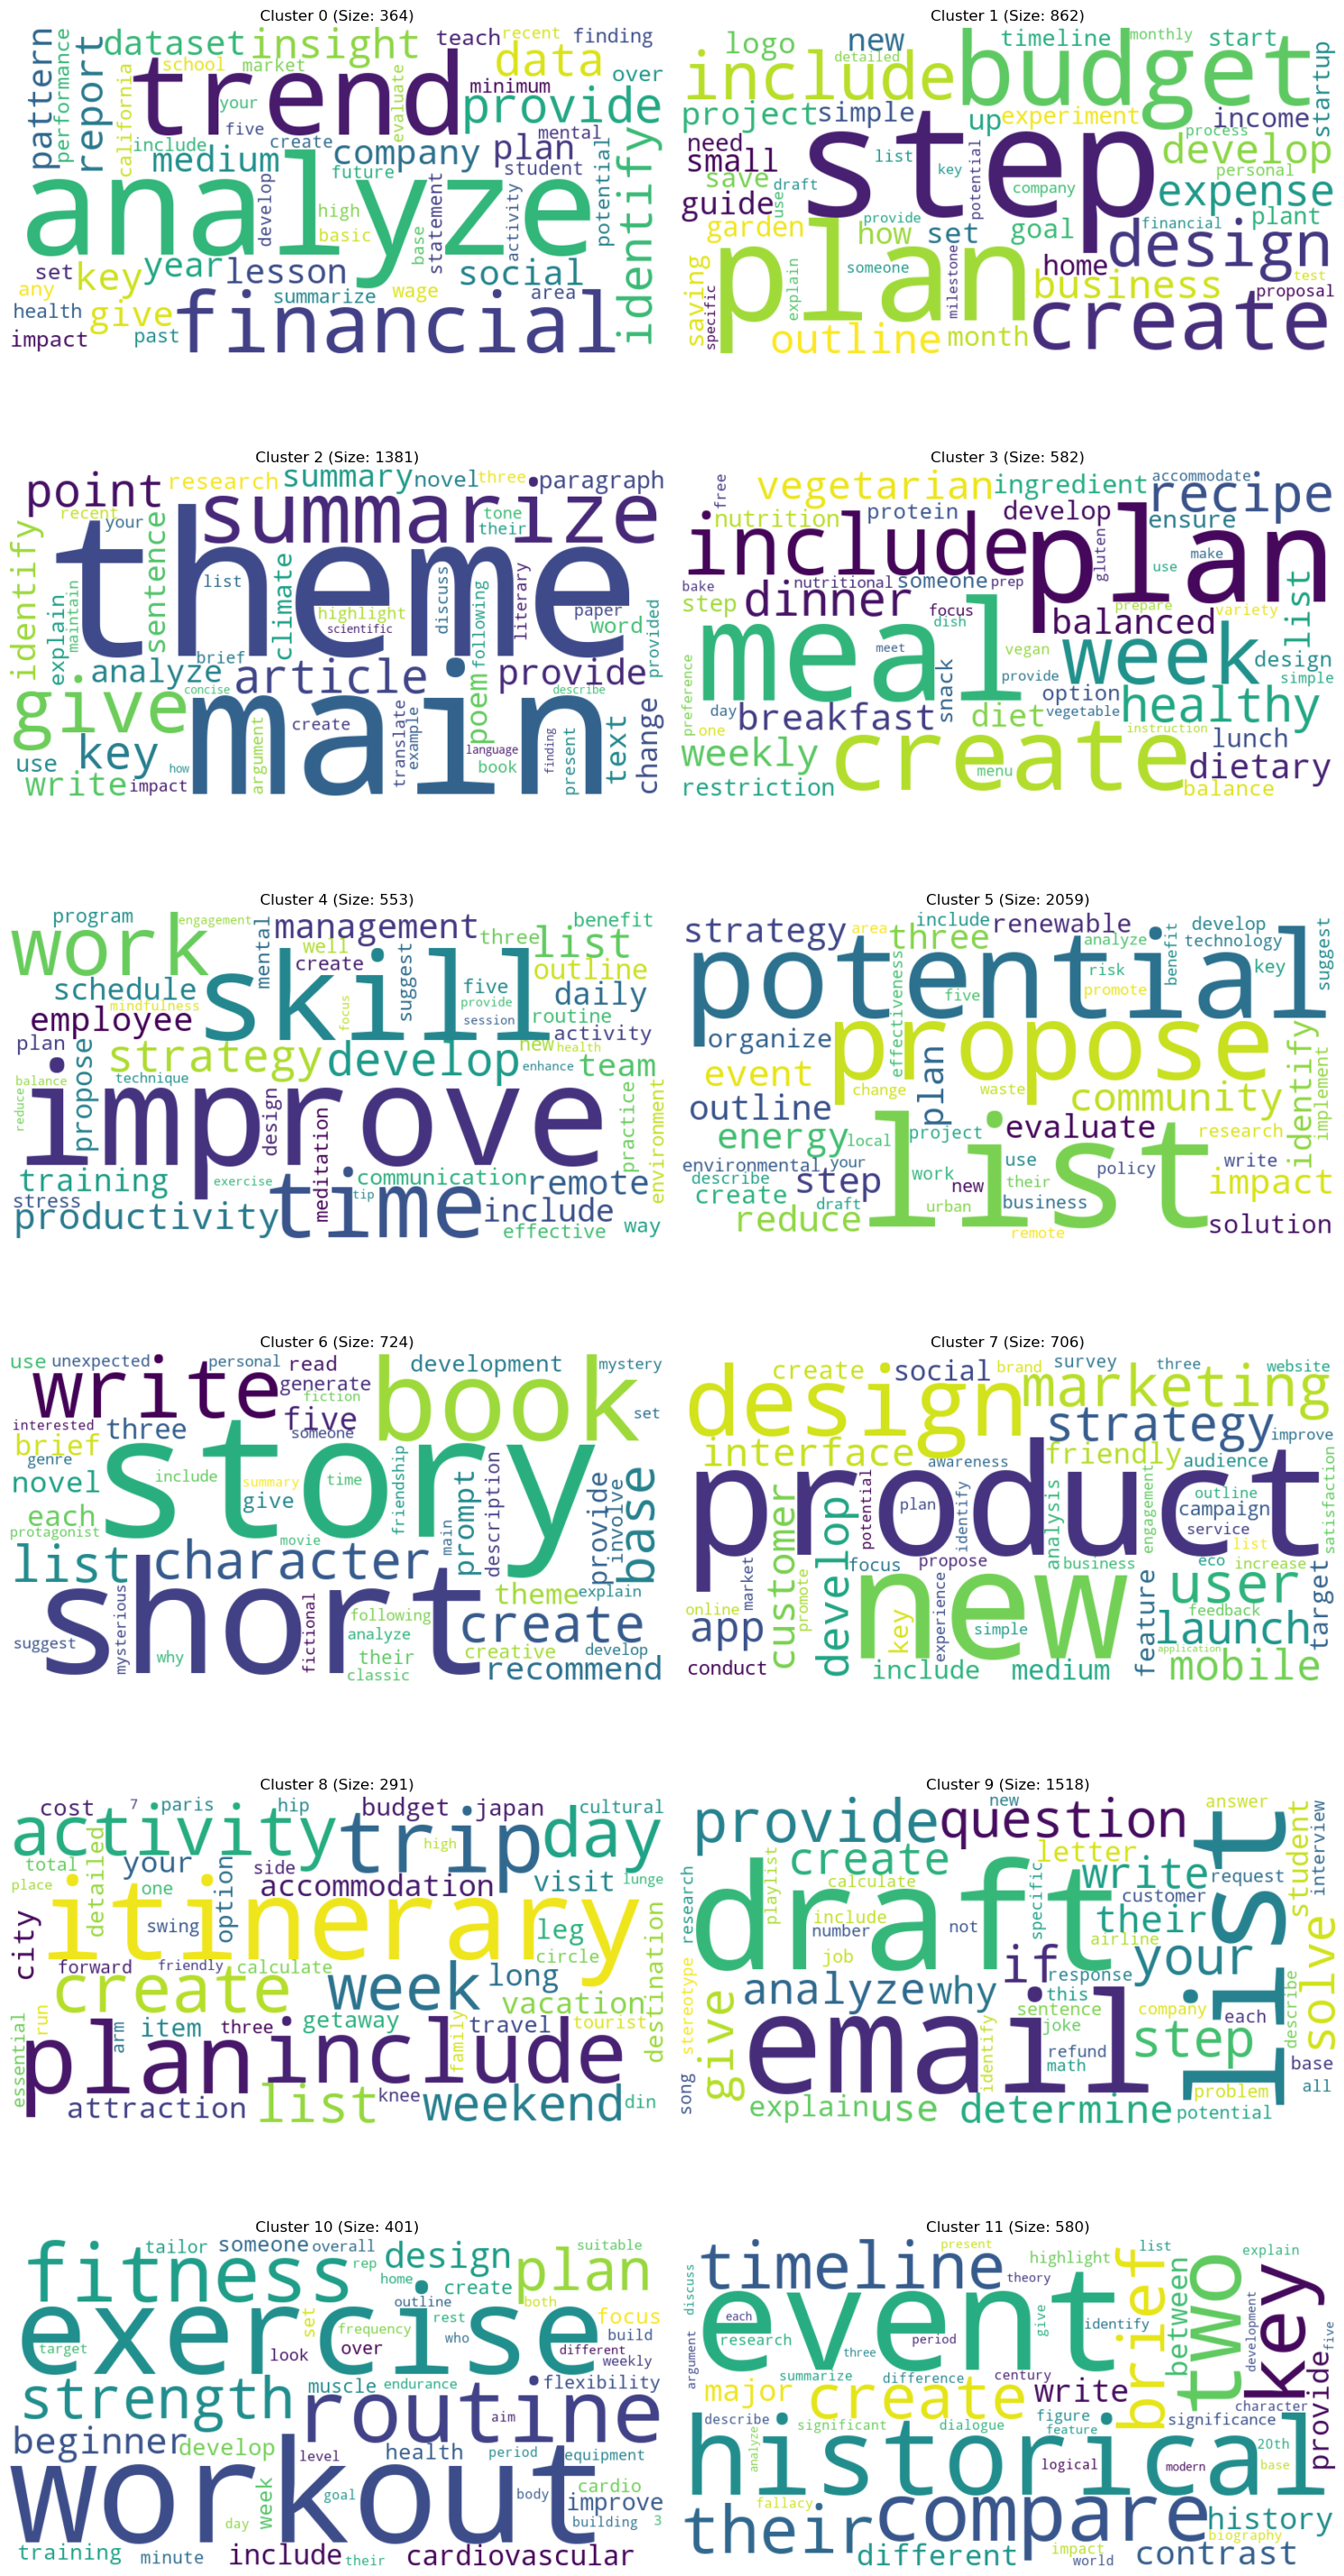


Example instructions from each cluster:

Cluster 0 examples:
- Analyze the data set provided to identify trends and make recommendations for future actions.
- Analyze the given data set to identify trends and patterns, providing visualizations and insights.
- Create a detailed outline for a research paper on the impact of social media on mental health, including key sections and subtopics to be covered.

Cluster 1 examples:
- Create a step-by-step guide for setting up a home wi-fi network, including troubleshooting tips.
- Create a detailed project plan for organizing a community event, including key milestones and deadlines.
- Develop a project plan outlining the key steps, timeline, and resources needed to achieve a specific goal.

Cluster 2 examples:
- Create a summary of the provided text, highlighting the main points and key details.
- Analyze the given text and summarize its main points in a concise paragraph.
- Fill in the blank with a word or phrase: "the quick brown fox jumps

In [30]:
from sklearn.mixture import GaussianMixture

scaler = StandardScaler()
scaled_embedding = scaler.fit_transform(embedding)

# Ensure data is in the correct format
scaled_embedding = np.array(scaled_embedding, dtype=np.float64)

# Apply Gaussian Mixture Model
gmm = GaussianMixture(
    n_components=12,           # Number of clusters/components
    random_state=42,          # For reproducibility
    covariance_type='full',   # Full covariance matrix
    n_init=5                  # Number of initializations to perform
)
clusters = gmm.fit_predict(scaled_embedding)

# Create a figure with subplots for each cluster
unique_clusters = sorted(np.unique(clusters))
n_clusters = len(unique_clusters)
fig = plt.figure(figsize=(15, 5 * ((n_clusters + 1) // 2)))

# For each cluster, create a wordcloud
for idx, cluster_id in enumerate(unique_clusters):
    # Get indices of points in this cluster
    cluster_mask = (clusters == cluster_id)
    
    # Get all words from instructions in this cluster
    cluster_words = []
    # Use a regular loop instead of numpy array operations
    for i, instruction in enumerate(filtered_lines):
        if cluster_mask[i]:
            cluster_words.extend(instruction)
    
    # Create word frequency dict
    word_freq = Counter(cluster_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(word_freq)
    
    # Add subplot
    ax = fig.add_subplot(((n_clusters + 1) // 2), 2, idx + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    label = "Noise Cluster" if cluster_id == -1 else f"Cluster {cluster_id}"
    ax.set_title(f'{label} (Size: {cluster_mask.sum()})')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print some example instructions from each cluster
print("\nExample instructions from each cluster:")
for cluster_id in unique_clusters:
    cluster_mask = (clusters == cluster_id)
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"\n{label} examples:")
    # Get original instructions (before lemmatization)
    cluster_examples = [line for i, line in enumerate(lines) if cluster_mask[i]]
    # Print first 3 examples
    for example in cluster_examples[:3]:
        print(f"- {example}")